## Images Visual Relationship project
This project is based on the [Google AI Open Images - Visual Relationship Track Kaggle Challenge](https://www.kaggle.com/c/google-ai-open-images-visual-relationship-track).

The challenge is to build the best performing algorithm for automatically detecting relationships triplets.

In [2]:
import argparse
import csv
import pickle
import os
import sys
import random
import math
import re
import time
import wget
import numpy as np
from PIL import Image
import cv2
import glob
from shutil import copyfile
import collections
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
import parallel 
import concurrent.futures

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import __version__ as keras_version
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Cropping2D, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Visualizations will be shown in the notebook.
%matplotlib inline

# https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb
import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image, compute_resize_scale
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# set tf backend to allow memory to grow, instead of claiming everything
#import tensorflow as tf

#def get_session():
#    config = tf.ConfigProto()
#    config.gpu_options.allow_growth = True
#    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
#keras.backend.tensorflow_backend.set_session(get_session())

# Directory to save logs and trained model
# https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5
RCNN_COCO_MODEL_URL = "https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5"
RCNN_COCO_MODEL = "resnet50_coco_best_v2.1.0.h5"

# Local path to trained weights file
MODEL_PATH = os.path.join(os.path.join(os.getcwd(), "pretrained_models"), RCNN_COCO_MODEL)

# Download COCO trained weights from Releases if needed
if not os.path.exists(MODEL_PATH):
    print ('Downloading COCO trained weights: {} to path: {}'.format(RCNN_COCO_MODEL, MODEL_PATH))  
    wget.download(RCNN_COCO_MODEL_URL, MODEL_PATH)  
else:
    print ('Using COCO trained weights: {} from path: {}, downloaded from: {}'.format(
        RCNN_COCO_MODEL, MODEL_PATH, RCNN_COCO_MODEL_URL))
    
import warnings
warnings.simplefilter('ignore', UserWarning)

Using TensorFlow backend.


Using COCO trained weights: resnet50_coco_best_v2.1.0.h5 from path: /home/powell/work/scpd/vision_project/visual_relationship/pretrained_models/resnet50_coco_best_v2.1.0.h5, downloaded from: https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5


### Helper APIs

In [3]:
"""
Helper API
"""
def get_fid(image_path):
        return os.path.basename(image_path).split('.')[0]

def process_labels_from_csv_input(prefix='data/raw', 
                                  labels_csv_fname_list=['class-descriptions-boxable.csv', 
                                                         'class-descriptions.csv']):
    label_dict = {}
    # Process the labels info files and create a key value pair
    for flabel_csv in labels_csv_fname_list:
        with open(os.path.join(prefix, flabel_csv)) as f:
            rows = csv.reader(f)
            for row in rows:
                if row[0] in label_dict:
                    #print('Label already exists: {}:{}, new label: {}:{}'.
                    #       format(row[0], label_dict[row[0]], row[0], row[1]))
                    assert row[1] == label_dict[row[0]]
                label_dict[row[0]]=row[1]
                
    return label_dict
                
def process_raw_csv_input(prefix='data/raw', train_csv_fname = 'challenge-2018-train-vrd.csv', 
                          labels_csv_fname_list = ['class-descriptions-boxable.csv', 'class-descriptions.csv']):
    """
    Process the labels from given label names and create three categories
    a. Entity
    b. Attribute
    c. Relationship
    """
    
    label_dict = process_labels_from_csv_input(prefix, labels_csv_fname_list)
    
    # Process the training data and create x, y i.e x->(imageid, (bounding box data)) y->(label1,label2,relationship)
    label1_dict = collections.defaultdict(int)
    label2_dict = collections.defaultdict(int)
    relationship_dict = collections.defaultdict(int)
    xy_list = []
    missing_label_dict = {}
    ignore_header = True
    miss_count = 0
    with open(os.path.join(prefix, train_csv_fname)) as f:
        rows = csv.reader(f)
        for row in rows:
            miss = False
            if ignore_header:
                ignore_header = False
                continue
            x = (row[0], (row[3:11]))
            y = (row[1], row[2], row[11])
            if y[0] not in label_dict:
                if y[0] not in missing_label_dict:
                    print('Label1 missing: {}'.format(y[0]))
                miss = True
                missing_label_dict[y[0]] = y[0]
            else:
                label1_dict[y[0]] += 1
            if y[1] not in label_dict:
                if y[1] not in missing_label_dict:
                    print('Label2 missing: {}, label1 : {}, relation: {}'.format(y[1], label_dict[y[0]], row[11]))
                miss_count += 1
                miss = True
                missing_label_dict[y[1]] = y[1]
            else:
                label2_dict[y[1]] += 1
            relationship_dict[y[2]] += 1
            if miss is False:
                xy_list.append((x, y))
    print ("Missing label count: {}".format(miss_count))             
    return xy_list, (label1_dict, label2_dict, relationship_dict), label_dict

def get_data_dir_from_raw_single_dir(X_dict, prefix='data', dir_list=None, out_dir='processed'):
    X_fset = set()
    copy_prefix_dir = os.path.join(prefix, out_dir)
    for d in dir_list:
        copy_dir = os.path.join(os.getcwd(), os.path.join(copy_prefix_dir, d))
        os.makedirs(copy_dir, exist_ok=True)
        flist = glob.glob(os.path.join(os.path.join(prefix, d), '*.jpg'))
        for f in flist:
            fid = os.path.basename(f).split('.')[0]
            if fid in X_dict:
                dst_f = os.path.join(copy_dir, os.path.basename(f))
                X_fset.add(dst_f)
                X_dict[fid] = (X_dict[fid], dst_f)
                copyfile(os.path.join(os.getcwd(), f), dst_f)
                
    return X_fset

def get_data_from_dir_recursive(xy_list, prefix='data/processed', dir_input='raw'):
    """
    Load the file path for each image id. The dictionary can only have image file path since
    a single image can have multiple labels i.e multiple y values.

    Example of entry in xy_list:
    Train data xy_list[0]: (
                            ('fe58ec1b06db2bb7', ['0.005', '0.033125', '0.58', '0.62777776', 
                                                   '0.005', '0.033125', '0.58', '0.62777776']) , 
                            ('/m/04bcr3', '/m/083vt', 'is'))
    """
    cwd = os.getcwd()
    xy_list_valid = []      # xy_list that has valid image files available
    X_id_to_file_dict = {}  # id of the image to file dictionary
    def process_files(dir_path):
        flist = glob.glob(os.path.join(dir_path, '*.jpg'))
        print('Processing dir: {}, image count: {}'.format(dir_path, len(flist)))
            
        for f in flist:
            fid = os.path.basename(f).split('.')[0]
            if fid in X_id_to_file_dict:
                print ('Error id exists twice: {}-{}-{}'.format(fid, f, X_id_to_file_dict[fid]))
                continue
            else:
                X_id_to_file_dict[fid] = os.path.join(cwd, f)
                
    def helper(dir_input_full):
        l = next(os.walk(dir_input_full))[1]
        if len(l) == 0:   
            return
        
        for d in l:
            dir_path = os.path.join(dir_input_full, d)
            process_files(dir_path)
            helper(dir_path)
    
    process_files(os.path.join(prefix, dir_input))
    helper(os.path.join(prefix, dir_input))
    
    for xy in xy_list:
        if xy[0][0] in X_id_to_file_dict:
            xy_list_valid.append(xy)

    return xy_list_valid, X_id_to_file_dict

def bounding_box_to_plt(image, b):
    """
    Convert one bounding box data into what mathplotlib understands
    [XMin1,    XMax1,     YMin1,   YMax1,        XMin2,    XMax2,    YMin2,   YMax2]
    ['0.005', '0.033125', '0.58', '0.62777776', '0.005', '0.033125', '0.58', '0.62777776']
    for: https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle
    """
    xsize = image.shape[1]
    ysize = image.shape[0]
    xy = (int(float(b[0]) * xsize), int(float(b[2]) * ysize))   # (XMin1 * xsize, YMin1 * ysize)
    width = int(float(b[1]) * xsize) - xy[0]        # XMax1 * xsize - XMin1 * xsize
    height = int(float(b[3]) * ysize) - xy[1]       # YMax1 * ysize - Ymin * ysize 
    return (xy, width, height)

def two_bounding_boxes_to_plt(image, b):
    """
    Convert two bounding box data into what mathplotlib understands
    """
    return [bounding_box_to_plt(image, b[0:4]), bounding_box_to_plt(image, b[4:len(b)])]
    
def show_images(images,titles=None, bounding_boxes_list=[]):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    
    for i in range(0, len(images)):
        image = images[i]
        title = "None"
        if titles is not None and len(titles) > i:
            title = titles[i]
        
        bounding_boxes = None
        if bounding_boxes_list is not None and len(bounding_boxes_list) > i:
            bounding_boxes = bounding_boxes_list[i]

        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if len(image.shape) == 2 or image.shape[2] == 1: # Is image grayscale?
            plt.imshow(np.resize(image, (image.shape[0], image.shape[1])), interpolation="bicubic", cmap="gray") # Only place in this blog you can't replace 'gray' with 'grey'
        else:
            plt.imshow(image, interpolation="bicubic")
            if bounding_boxes is not None:
                box1, box2 = two_bounding_boxes_to_plt(image, bounding_boxes)
                rect1 = patches.Rectangle((box1[0]),box1[1],box1[2],linewidth=2,edgecolor='y',facecolor='none')
                rect2 = patches.Rectangle((box2[0]),box2[1],box2[2],linewidth=2,edgecolor='g',facecolor='none')
                a.add_patch(rect1)
                a.add_patch(rect2)
        if titles is not None:
            a.set_title(title + ' {}x{}'.format(image.shape[0], image.shape[1]))
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.axis('off')
    plt.show()
    
def show_given_images(xy_given_list, id_to_file_dict):
    img_list = []
    label_list = []
    bounding_boxes_list = []
    for xy in xy_given_list:
        fid = xy[0][0]
        bounding_boxes_list.append(xy[0][1])
        y = xy[1]
        label1 = y[0]
        label2 = y[1]
        if label1 in label_dict:
            label1 = label_dict[label1]
        if label2 in label_dict:
            label2 = label_dict[label2]
        
        label_list.append('{} {} {}'.format(label1, y[2], label2))
        if fid not in id_to_file_dict:
            print ('Error could not find id: {} in id_to_file_dict'.format(fid))
            raise 
        img_list.append(cv2.cvtColor(cv2.imread(id_to_file_dict[fid], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB))
    print ('Label_list" {}'.format(label_list))
    show_images(img_list, titles=label_list, bounding_boxes_list=bounding_boxes_list)
    
def show_random_images(xy_given_list, id_to_file_dict, count=4):
    xy_rnd_idx_list = np.random.choice(len(xy_given_list), count, replace=False)
    xy_rnd_list = [ xy_given_list[x] for x in xy_rnd_idx_list]
    show_given_images(xy_rnd_list, id_to_file_dict)
    return xy_rnd_list

def _resize_job_helper(kv_list, output_dir, xsize=514, ysize=343):
    out_list = []
    for k, v in kv_list:
        if v is None:
            out_list.append((k, v))
            continue
        try:
            if os.path.isfile(v) is False:
                print('Invalid file failed for {}'.format(v))
                out_list.append((k, v))
                continue
        except:
            print('Invalid file failed for {}'.format(v))
            raise
        out_file = os.path.join(output_dir, os.path.basename(v))
        
        # If the file exists then 
        if os.path.isfile(out_file):
            out_list.append((k, out_file))
            continue
 
        resize_img = cv2.resize(cv2.imread(v, cv2.IMREAD_COLOR),(xsize, ysize))
        out_file = os.path.join(output_dir, os.path.basename(v))
        cv2.imwrite(out_file, resize_img)
        
        out_list.append((k, out_file))
    return out_list

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def resize_all(id_to_file_dict, prefix='data/processed', output_dir='resized_images', xsize=514, ysize=343, 
               count=None):
    output_dir = os.path.join(os.getcwd(), os.path.join(prefix, output_dir))
    os.makedirs(output_dir, exist_ok=True)

    aprun = parallel.ParallelExecutor(n_jobs=7)
    
    chunked_list = list(chunks(list(id_to_file_dict.items()), int(len(id_to_file_dict.items())/8)))
    
    print ('chunk list size: {}'.format(len(chunked_list)))

    out_list = aprun(bar='tqdm')(delayed(_resize_job_helper)(kv_list, output_dir, xsize, ysize) 
                                          for kv_list in chunked_list)
    ret_dict = dict()
    for l in out_list:
        for k, v in l:
            ret_dict[k] = v
    return ret_dict

### Resize and data prep code
The following few cells help with saving resized images. Had to resize them to 96x96 to avoid out of memory issues. Have to fix these buy bumping up the memory on the box. Currently it only has 32GB. The full sized images are 28GB. Reducing them to 96x96 gets us to 803MB.

In [130]:
# Uncomment if you want to resize the data again
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input()
xy_list, X_id_to_file_dict = get_data_from_dir_recursive(xy_list, dir_input='raw')
#X_resized_id_to_file_dict = resize_all(X_id_to_file_dict)

Label2 missing: /m/02gy9n, label1 : Bottle, relation: is
Missing label count: 20644
Processing dir: data/processed/raw, image count: 0
Processing dir: data/processed/raw/train_01, image count: 11290
Processing dir: data/processed/raw/train_06, image count: 10789
Processing dir: data/processed/raw/train_07, image count: 10890
Processing dir: data/processed/raw/train_04, image count: 11316
Processing dir: data/processed/raw/train_05, image count: 11108
Processing dir: data/processed/raw/train_00, image count: 11310
Processing dir: data/processed/raw/train_08, image count: 7368
Processing dir: data/processed/raw/test, image count: 0
Processing dir: data/processed/raw/train_02, image count: 11209
Processing dir: data/processed/raw/train_03, image count: 11219


In [129]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input()
s = set(list(train_data_label_tuple[0].keys()))
for k in train_data_label_tuple[1].keys():
    s.add(k)
    
print ('Length of s: {}'.format(len(s)))

Label2 missing: /m/02gy9n, label1 : Bottle, relation: is
Missing label count: 20644
Length of s: 61


Showing resized image with resized bounding box examples with bounding boxes
Label_list" ['Chair at Table', 'Man at Table', 'Handbag is Leather', 'Bottle is Plastic']


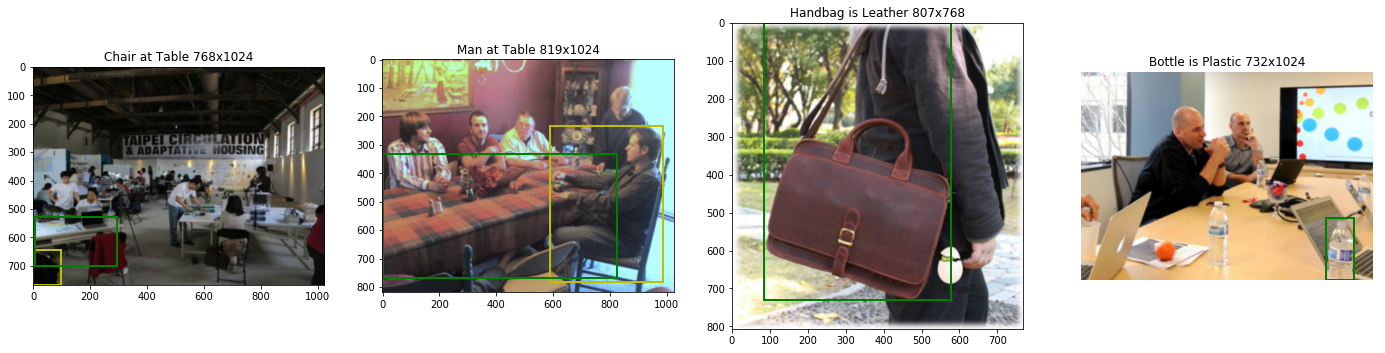

Showing resized but with original bounding box data image examples with bounding boxes


NameError: name 'X_resized_id_to_file_dict' is not defined

In [133]:
print ('Showing resized image with resized bounding box examples with bounding boxes')

showen_list = show_random_images(xy_list, X_id_to_file_dict, count=4)

print ('Showing resized but with original bounding box data image examples with bounding boxes')

show_given_images(showen_list, X_resized_id_to_file_dict)

In [ ]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input()
xy_list, X_resized_id_to_file_dict = get_data_from_dir_recursive(xy_list, dir_input='resized_images')

In [ ]:
print ("Size of xy_list: {}".format(len(xy_list)))
print ("xy_list[0]: {}, xy_list[0][0]: {}".format(xy_list[0], xy_list[0][0]))
print ("Example file: {}".format(X_resized_id_to_file_dict[xy_list[0][0][0]]))

In [ ]:
random_image_list = show_random_images(xy_list, X_resized_id_to_file_dict, count=4)

### Load the images and prep for the network.

In [56]:
# Output data for retinanet to train the labels that work for us i.e
# the object label and subject label
def prepare_dataset_for_retinanet(xy_train_list, xy_test_list, id_to_file_dict, 
                                  image_size_cache='image_size_cache.p', count=None):
    def get_fid(image_path):
        return os.path.basename(image_path).split('.')[0]

    def fix_boxes(box, xsize, ysize):
        # input is Xmin, Xmax, Ymin, Ymax in %/faction of xsize and ysize
        # retinanet needs x1,y1,x2,y2 in absolute of xsize and ysize
        b = [ int(float(box[0])*xsize), int(float(box[2])*ysize), int(float(box[1])*xsize), 
             int(float(box[3])*ysize) ]
        """
        Some of the bounding boxes does not satisfyin invariant constraint
        x1 < x2 and y1 < y2. In such cases retinanet ignores those images.
        Try to fix them here?. Fortunately they are only few such images.
        if b[0] > b[2]:
            tmp = b[2]
            b[2] = b[0]
            b[0] = tmp
        if b[1] > b[3]:
            tmp = b[3]
            b[3] = b[1]
            b[1] = tmp
        """
        return b
    
    if os.path.isfile(image_size_cache):
        with open(image_size_cache, 'rb') as f:
            image_size_dict = pickle.load(f)
    else:
        image_size_dict = {}

    print ('Loaded dict size: {}'.format(len(image_size_dict)))
    update_dict = [False]
    def get_dataset(xy_input_list):
        dataset = {'features': [], 'bounding_box_with_label': []}
        c = 0
        for xy in xy_input_list:
            # Add for first label
            if count is not None and c > count:
                break
            c += 1
            dataset['features'].append(id_to_file_dict[xy[0][0]])
            fid = get_fid(xy[0][0])
            if fid in image_size_dict:
                xsize, ysize = image_size_dict[fid]
            else:
                img = cv2.imread(id_to_file_dict[xy[0][0]], cv2.IMREAD_COLOR)
                xsize = img.shape[1]
                ysize = img.shape[0]
                image_size_dict[fid] = (xsize, ysize)
                update_dict[0] = True

            dataset['bounding_box_with_label'].append(fix_boxes(xy[0][1][0:4], xsize, ysize) + [str(xy[1][0])])
            # Add for second label       
            dataset['features'].append(id_to_file_dict[xy[0][0]])
            dataset['bounding_box_with_label'].append(
            fix_boxes(xy[0][1][4:len(xy[0][1])], xsize, ysize) + [str(xy[1][1])])
        return dataset

    
    dataset_train = get_dataset(xy_input_list=xy_train_list)
    dataset_test = get_dataset(xy_input_list=xy_test_list)
    
    print ('Dict size: {}, updated: {}'.format(len(image_size_dict), update_dict[0]))
    if update_dict[0] is True:
        print ('output image size cache for reuse: {}'.format(image_size_cache))
        with open(image_size_cache, 'wb') as f:
            pickle.dump(image_size_dict, f)

    return dataset_train, dataset_test

def prepare_dataset_for_model(xy_train_list, xy_test_list, id_to_file_dict, count=None):
    image_size_dict = {}
    def get_dataset(xy_input_list):
        dataset = {'features': [],  'labels_orig':[]}
        c = 0
        for xy in xy_input_list:
            # Add for first label
            if count is not None and c > count:
                break
            c += 1
            dataset['features'].append(id_to_file_dict[xy[0][0]])
            dataset['labels_orig'].append(xy[1])
        return dataset
    
    dataset_train = get_dataset(xy_input_list=xy_train_list)
    dataset_test = get_dataset(xy_input_list=xy_test_list)
    
    return dataset_train, dataset_test
    
# Write the CSV annotations
def write_csv_annotations_for_retinanet(features, labels, 
                                        annotations_file='fullsize_train_annotations.csv'):
    with open(annotations_file, mode='w', newline='', encoding='utf8') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for X, Y in zip(features, labels):
            row = [X] + Y
            writer.writerow(row)
            
def write_csv_classes_for_retinanet(train_data_label_tuple_input, classes_file='fullsize_classes.csv'):
    labels_combined_dict = set()
    # Make sure we have unique set of labels only the subject and object label. Should not contain
    # relationship label.
    for label in train_data_label_tuple[0].keys():
        labels_combined_dict.add(label)
    for label in train_data_label_tuple[1].keys():
        labels_combined_dict.add(label)

    with open(classes_file, mode='w', newline='', encoding='utf8') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        count = 0
        for label in labels_combined_dict:
            row = [str(label), count]
            writer.writerow(row)
            count+=1

### Prepare the dataset for retinatnet training.

We take the full sized images label set given by the **challenge-2018-train-vrd.csv** which has 354122 entries and prepare it by breaking each entry into two examples i.e 1 per given bounding box and label.

The following step will take some time since retinanet input needs bounding box in absolute dimensions rather than the perctange/fractional input given by OID data.

In [4]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input(
    prefix='data/raw', train_csv_fname = 'challenge-2018-train-vrd.csv', 
    labels_csv_fname_list = ['class-descriptions-boxable.csv', 'class-descriptions.csv'])
xy_full_list, X_full_id_to_file_dict = get_data_from_dir_recursive(xy_list, dir_input='raw')

Label2 missing: /m/02gy9n, label1 : Bottle, relation: is
Missing label count: 20644
Processing dir: data/processed/raw, image count: 0
Processing dir: data/processed/raw/train_01, image count: 11290
Processing dir: data/processed/raw/train_06, image count: 10789
Processing dir: data/processed/raw/train_07, image count: 10890
Processing dir: data/processed/raw/train_04, image count: 11316
Processing dir: data/processed/raw/train_05, image count: 11108
Processing dir: data/processed/raw/train_00, image count: 11310
Processing dir: data/processed/raw/train_08, image count: 7368
Processing dir: data/processed/raw/test, image count: 0
Processing dir: data/processed/raw/train_02, image count: 11209
Processing dir: data/processed/raw/train_03, image count: 11219


In [10]:
s = set(list(train_data_label_tuple[0].keys()))
for k in train_data_label_tuple[1].keys():
    s.add(k)
    
print ('Size of labels: {}'.format(len(s)))
s_list = list(s)
for i in range(0, len(s_list)):
    print ('{}: {}-{}'.format(i, s_list[i], label_dict[s_list[i]]))

Size of labels: 61
0: /m/04dr76w-Bottle
1: /m/04yx4-Man
2: /m/01599-Beer
3: /m/04ctx-Knife
4: /m/01_5g-Chopsticks
5: /m/026t6-Drum
6: /m/01bl7v-Boy
7: /m/0h8my_4-Tennis racket
8: /m/03bt1vf-Woman
9: /m/07y_7-Violin
10: /m/01940j-Backpack
11: /m/0dv9c-Racket
12: /m/02p5f1q-Coffee cup
13: /m/0l14j_-Flute
14: /m/0h2r6-Van
15: /m/0cvnqh-Bench
16: /m/080hkjn-Handbag
17: /m/05ctyq-Tennis ball
18: /m/0bt9lr-Dog
19: /m/0cmx8-Spoon
20: /m/083vt-Wood
21: /m/05z87-Plastic
22: /m/01f91_-Pretzel
23: /m/0hg7b-Microphone
24: /m/0k4j-Car
25: /m/08pbxl-Monkey
26: /m/05r655-Girl
27: /m/0bwd_0j-Elephant
28: /m/029bxz-Oven
29: /m/078jl-Snake
30: /m/03m3pdh-Sofa bed
31: /m/02jvh9-Mug
32: /m/04_sv-Motorcycle
33: /m/01s55n-Suitcase
34: /m/0199g-Bicycle
35: /m/0wdt60w-Rugby ball
36: /m/02hj4-Dolphin
37: /m/0pg52-Taxi
38: /m/050k8-Mobile phone
39: /m/0dnr7-Textile
40: /m/04bcr3-Table
41: /m/01226z-Football
42: /m/078n6m-Coffee table
43: /m/03ssj5-Bed
44: /m/05r5c-Piano
45: /m/0584n8-Briefcase
46: /m/0342h-Guit

### Break the input set to train and test set.

Before generating the CSV input to Retinanet break the data up. So that we can use test set for evaulating the model and use the same test set for final model evaulation.

In [29]:
def train_test_split(xy_input_list, test_size=0.20, seed=42):
    np.random.seed(seed=42)
    np.random.shuffle(xy_input_list)
    split_idx = int(round(float(len(xy_input_list)) * (1.0-test_size)))
    return xy_input_list[0:split_idx], xy_input_list[split_idx:len(xy_input_list)]

In [30]:
xy_train_list, xy_test_list = train_test_split(xy_input_list=xy_full_list)

In [31]:
print('Size of full set: {}, size of train set: {}, size of test set: {}, split %: {}'.format(
    len(xy_full_list), len(xy_train_list), len(xy_test_list), round(100*float(len(xy_test_list))/len(xy_full_list), 3)))

Size of full set: 354122, size of train set: 283298, size of test set: 70824, split %: 20.0


In [45]:
# Prepare dataset for model without the bounding boxes from full size images 
dataset_model_train, dataset_model_test = prepare_dataset_for_model(xy_train_list, xy_test_list, 
                                                                    X_full_id_to_file_dict)

In [33]:
# Print an example from datatset to make sure it is sane.
print ('Size of dataset: {}'.format(len(dataset_model_train['features'])))
rnd_idx = np.random.choice(len(dataset_model_train['features'])-1, 2, replace=False)
for i in rnd_idx:
    print ('dataset[features][{}]: {}, dataset[labels_orig][{}]: {}'.format(i,
        dataset_model_train['features'][i], i, dataset_model_train['labels_orig'][i]))
    print ('dataset[features][{}]: {}, dataset[labels_orig]][{}]: {}'.format(i+1,
        dataset_model_train['features'][i+1], i+1, dataset_model_train['labels_orig'][i+1]))

Size of dataset: 283298
dataset[features][256041]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_03/9dc4626fcc47ebf0.jpg, dataset[labels_orig][256041]: ('/m/01mzpv', '/m/04lbp', 'is')
dataset[features][256042]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_03/9f2098c54ee4851e.jpg, dataset[labels_orig]][256042]: ('/m/03bt1vf', '/m/01mzpv', 'on')
dataset[features][26566]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_06/3fed82d56fb20c1c.jpg, dataset[labels_orig][26566]: ('/m/01mzpv', '/m/04lbp', 'is')
dataset[features][26567]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_05/54a0337d4660fa5f.jpg, dataset[labels_orig]][26567]: ('/m/04yx4', '/m/0342h', 'plays')


In [ ]:
# Print an example from datatset to make sure it is sane.
print ('Size of dataset: {}'.format(len(dataset_model_test['features'])))
rnd_idx = np.random.choice(len(dataset_model_test['features'])-1, 2, replace=False)
for i in rnd_idx:
    print ('dataset[features][{}]: {}, dataset[labels_orig][{}]: {}'.format(i,
        dataset_model_test['features'][i], i, dataset_model_test['labels_orig'][i]))
    print ('dataset[features][{}]: {}, dataset[labels_orig][{}]: {}'.format(i+1,
        dataset_model_test['features'][i+1], i+1, dataset_model_test['labels_orig'][i+1]))

In [58]:
# Prepare dataset for reinanet from full size images 
dataset_train, dataset_test = prepare_dataset_for_retinanet(xy_train_list, xy_test_list, 
                                                            X_full_id_to_file_dict)

Loaded dict size: 0
Dict size: 96499, updated: True
output image size cache for reuse: image_size_cache.p


In [59]:
# Print an example from datatset to make sure it is sane.
print ('Size of dataset: {}'.format(len(dataset_train['features'])))
rnd_idx = np.random.choice(len(dataset_train['features'])-1, 2, replace=False)
for i in rnd_idx:
    print ('dataset[features][{}]: {}, dataset[bounding_box_with_label][{}]: {}'.format(i,
        dataset_train['features'][i], i, dataset_train['bounding_box_with_label'][i]))
    print ('dataset[features][{}]: {}, dataset[bounding_box_with_label][{}]: {}'.format(i+1,
        dataset_train['features'][i+1], i+1, dataset_train['bounding_box_with_label'][i+1]))

Size of dataset: 566596
dataset[features][303633]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_01/d5638e3bb0c6ea0a.jpg, dataset[bounding_box_with_label][303633]: [620, 470, 916, 576, '/m/078n6m']
dataset[features][303634]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_06/3eae94aea80f03ec.jpg, dataset[bounding_box_with_label][303634]: [363, 96, 609, 636, '/m/03bt1vf']
dataset[features][186096]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_07/139ab70a11364743.jpg, dataset[bounding_box_with_label][186096]: [560, 456, 627, 523, '/m/01mzpv']
dataset[features][186097]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_07/139ab70a11364743.jpg, dataset[bounding_box_with_label][186097]: [560, 456, 627, 523, '/m/083vt']


In [60]:
# Print an example from datatset to make sure it is sane.
print ('Size of dataset: {}'.format(len(dataset_test['features'])))
rnd_idx = np.random.choice(len(dataset_test['features'])-1, 2, replace=False)
for i in rnd_idx:
    print ('dataset[features][{}]: {}, dataset[bounding_box_with_label][{}]: {}'.format(i,
        dataset_test['features'][i], i, dataset_test['bounding_box_with_label'][i]))
    print ('dataset[features][{}]: {}, dataset[bounding_box_with_label][{}]: {}'.format(i+1,
        dataset_test['features'][i+1], i+1, dataset_test['bounding_box_with_label'][i+1]))

Size of dataset: 141648
dataset[features][129708]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_05/4a7bc6d55eaef728.jpg, dataset[bounding_box_with_label][129708]: [68, 250, 140, 540, '/m/080hkjn']
dataset[features][129709]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_05/4a7bc6d55eaef728.jpg, dataset[bounding_box_with_label][129709]: [68, 250, 140, 540, '/m/0dnr7']
dataset[features][27745]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_01/da07367ccece6b59.jpg, dataset[bounding_box_with_label][27745]: [220, 298, 390, 480, '/m/083vt']
dataset[features][27746]: /home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_03/8b1b276e6927e35c.jpg, dataset[bounding_box_with_label][27746]: [223, 179, 888, 700, '/m/01s55n']


In [1]:
# Store the retinanet train data and train labels set as input for retinanet training from console.
annotations_file='fullsize_train_annotations.csv'
annotations_test_file='fullsize_test_annotations.csv'
classes_file='fullsize_classes.csv'

write_csv_annotations_for_retinanet(features=dataset_train['features'], 
                                    labels=dataset_train['bounding_box_with_label'], 
                                    annotations_file=annotations_file)
write_csv_annotations_for_retinanet(features=dataset_test['features'], 
                                    labels=dataset_test['bounding_box_with_label'], 
                                    annotations_file=annotations_test_file)
write_csv_classes_for_retinanet(train_data_label_tuple_input=train_data_label_tuple, classes_file=classes_file)

# Store the model train and test data as pickle.
import pickle
train_model_pickle ='fullsize_train_model.p'
test_model_pickle = 'fullsize_test_model.p'
with open(train_model_pickle, "wb" ) as f:
    pickle.dump(dataset_model_train, f)
with open(test_model_pickle, "wb") as f:
    pickle.dump(dataset_model_test, f)

NameError: name 'write_csv_annotations_for_retinanet' is not defined

In [18]:
annotations_file='fullsize_train_annotations.csv'
annotations_test_file='fullsize_test_annotations.csv'
classes_file='fullsize_classes.csv'
# Load the labels
label_tag_to_name = process_labels_from_csv_input()
def load_labels(label_tag_to_name, labels_file=classes_file):
    labels_to_names = {}
    # Process the labels info files and create a key value pair
    with open(labels_file, encoding='utf8') as f:
        rows = csv.reader(f)
        for row in rows:
            labels_to_names[int(row[1])]= (label_tag_to_name[row[0]], row[0])
    return labels_to_names

labels_to_names = load_labels(label_tag_to_name)
#print(label_tag_to_name)
print ("Number of labels loaded:{}".format(len(labels_to_names)))
for k, v in sorted(labels_to_names.items()):
    print ("{}: {}-{}".format(k, v[1], v[0]))

def load_labels_from_data(label_tag_to_name, data_file=annotations_file):
    labels_to_names = {}
    # Process the labels info files and create a key value pair
    with open(data_file, encoding='utf8') as f:
        rows = csv.reader(f)
        for row in rows:
            labels_to_names[row[-1]] = label_tag_to_name[row[-1]]
    return labels_to_names

train_labels_to_names = load_labels_from_data(label_tag_to_name, data_file=annotations_file)
print ("Number of unique labels from training data loaded: {}".format(len(train_labels_to_names)))
   
test_labels_to_names = load_labels_from_data(label_tag_to_name, data_file=annotations_test_file)
print ("Number of unique labels from test data loaded: {}".format(len(test_labels_to_names)))

missing_label_set = set(train_labels_to_names.keys()) - set(test_labels_to_names.keys())
print ("Total missing label count: {}".format(len(missing_label_set)))
for l in missing_label_set:
    print ("{}-{}".format(l, label_tag_to_name[l]))

Number of labels loaded:61
0: /m/078n6m-Coffee table
1: /m/01mzpv-Chair
2: /m/01226z-Football
3: /m/0h2r6-Van
4: /m/0pg52-Taxi
5: /m/0cvnqh-Bench
6: /m/0hg7b-Microphone
7: /m/0dnr7-Textile
8: /m/080hkjn-Handbag
9: /m/01f91_-Pretzel
10: /m/0k4j-Car
11: /m/078jl-Snake
12: /m/04_sv-Motorcycle
13: /m/0bwd_0j-Elephant
14: /m/02hj4-Dolphin
15: /m/029bxz-Oven
16: /m/019w40-Surfboard
17: /m/01s55n-Suitcase
18: /m/05r655-Girl
19: /m/01yrx-Cat
20: /m/05z87-Plastic
21: /m/03k3r-Horse
22: /m/050k8-Mobile phone
23: /m/0fx9l-Microwave oven
24: /m/0199g-Bicycle
25: /m/0h8my_4-Tennis racket
26: /m/04bcr3-Table
27: /m/07y_7-Violin
28: /m/04yx4-Man
29: /m/0584n8-Briefcase
30: /m/01599-Beer
31: /m/09tvcd-Wine glass
32: /m/0342h-Guitar
33: /m/04dr76w-Bottle
34: /m/0cmx8-Spoon
35: /m/026t6-Drum
36: /m/071p9-Ski
37: /m/0bt9lr-Dog
38: /m/08pbxl-Monkey
39: /m/03bt1vf-Woman
40: /m/01bl7v-Boy
41: /m/0l14j_-Flute
42: /m/04ctx-Knife
43: /m/05r5c-Piano
44: /m/0dv9c-Racket
45: /m/01940j-Backpack
46: /m/03ssj5-Bed
4

### Following is the training script run to train on console

```
$ cd keras-retinanet/
$ keras_retinanet/bin/train.py --imagenet-weights --freeze-backbone --no-evaluation --epochs 50  --image-min-side 343 --image-max-side 514 --batch-size 1 csv /home/powell/work/scpd/vision_project/visual_relationship/fullsize_train_annotations.csv /home/powell/work/scpd/vision_project/visual_relationship/fullsize_classes.csv
```

Resnet50 is the default backbone used by retinnet and its weights are frozen at training time.

*Total params: 37,627,657*
*Trainable params: 14,066,505*
*Non-trainable params: 23,561,152*

The epoch snapshots will be stored in **keras-retinanet/snapshots** and tensorboard log data is in **keras-retinanet/logs**.

The model output will be as follows:
**keras-retinanet/snapshots/resnet50_csv_epoch_number.h5**, example **keras-retinanet/snapshots/resnet50_csv_01.h5** after 1 epoch of training.

### Retinanet training epoch log

```
==================================================================================================
Total params: 37,627,657
Trainable params: 14,066,505
Non-trainable params: 23,561,152
__________________________________________________________________________________________________
None
Epoch 1/20
 1825/10000 [====>.........................] - ETA: 10:03 - loss: 3.5435 - regression_loss: 2.6480 - classification_loss: 0.8955keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:165: UserWarning: Image with id 28044 (shape (4016, 6016, 3)) contains the following invalid boxes: [[ 1551.  3678.  2123.  5497.]
 [ 1551.  3678.  2123.  5497.]].
  annotations['bboxes'][invalid_indices, :]
 8610/10000 [========================>.....] - ETA: 1:33 - loss: 3.0834 - regression_loss: 2.2973 - classification_loss: 0.7861keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:165: UserWarning: Image with id 53753 (shape (1024, 684, 3)) contains the following invalid boxes: [[  311.     0.   778.  1023.]
 [  311.     0.   778.  1023.]].
  annotations['bboxes'][invalid_indices, :]
10000/10000 [==============================] - 672s 67ms/step - loss: 3.0320 - regression_loss: 2.2583 - classification_loss: 0.7737

Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
Epoch 2/20
10000/10000 [==============================] - 677s 68ms/step - loss: 2.5522 - regression_loss: 1.8981 - classification_loss: 0.6541

Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
Epoch 3/20
 9327/10000 [==========================>...] - ETA: 45s - loss: 2.3845 - regression_loss: 1.7849 - classification_loss: 0.5996keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:165: UserWarning: Image with id 7462 (shape (768, 1024, 3)) contains the following invalid boxes: [[  686.   573.  1047.   767.]
 [  686.   573.  1047.   767.]].
  annotations['bboxes'][invalid_indices, :]
10000/10000 [==============================] - 680s 68ms/step - loss: 2.3778 - regression_loss: 1.7820 - classification_loss: 0.5958

Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
Epoch 4/20
10000/10000 [==============================] - 683s 68ms/step - loss: 2.2801 - regression_loss: 1.7167 - classification_loss: 0.5634

Epoch 00004: saving model to ./snapshots/resnet50_csv_04.h5
Epoch 5/20
10000/10000 [==============================] - 684s 68ms/step - loss: 2.1979 - regression_loss: 1.6629 - classification_loss: 0.5350

Epoch 00005: saving model to ./snapshots/resnet50_csv_05.h5
Epoch 6/20
10000/10000 [==============================] - 678s 68ms/step - loss: 2.1501 - regression_loss: 1.6251 - classification_loss: 0.5250

Epoch 00006: saving model to ./snapshots/resnet50_csv_06.h5
Epoch 7/20
10000/10000 [==============================] - 683s 68ms/step - loss: 2.1091 - regression_loss: 1.5989 - classification_loss: 0.5102

Epoch 00007: saving model to ./snapshots/resnet50_csv_07.h5
Epoch 8/20
10000/10000 [==============================] - 683s 68ms/step - loss: 2.0952 - regression_loss: 1.5792 - classification_loss: 0.5161

Epoch 00008: saving model to ./snapshots/resnet50_csv_08.h5
Epoch 9/20
10000/10000 [==============================] - 681s 68ms/step - loss: 2.0473 - regression_loss: 1.5351 - classification_loss: 0.5121

Epoch 00009: saving model to ./snapshots/resnet50_csv_09.h5
Epoch 10/20
10000/10000 [==============================] - 2759s 276ms/step - loss: 1.9969 - regression_loss: 1.5138 - classification_loss: 0.4831

Epoch 00010: saving model to ./snapshots/resnet50_csv_10.h5
```

### Load the Retinanet trained model and evaluate on test set

In [64]:
# Retinanet model testing
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('retinanet_snapshot', 'resnet50_csv_10.h5')

# load retinanet model
retinanet_model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
retinanet_model_infer = models.convert_model(retinanet_model)

print(retinanet_model_infer.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [ ]:
# evaluate the model
scores = retinanet_model_infer.evaluate(np.array(X_test), np.array(y_test))
print('\n{}: {}'.format(retinanet_model_infer.metrics_names[1], scores[1]*100))

Test image file: [ '/home/powell/work/scpd/vision_project/visual_relationship/data/processed/raw/train_00/e995ed5256327606.jpg'], shape: (835, 1024, 3)
Scale: 0.41077844311377243
processing time:  0.20351409912109375
Boxes: (1, 300, 4), scores: (1, 300), labels: (1, 300)
Label: Chair, Score: 0.6266483664512634
Label: Chair, Score: 0.5994594693183899
Label: Chair, Score: 0.4778156578540802
Label: Chair, Score: 0.41354426741600037
Label: Chair, Score: 0.37234261631965637
Label: Chair, Score: 0.36251014471054077
Label: Chair, Score: 0.3410912752151489
Label: Table, Score: 0.3330288529396057
Label: Man, Score: 0.33201315999031067
Label: Woman, Score: 0.3033345341682434


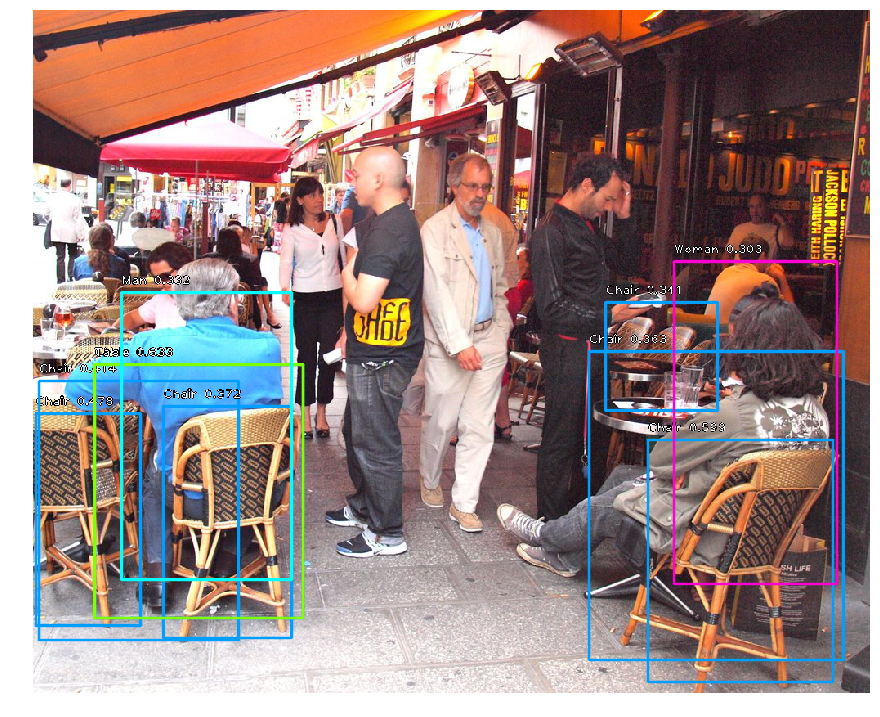

In [103]:
image_file = np.random.choice(dataset_model_train['features'], 1)

image_orig = read_image_bgr(np.random.choice(dataset_test['features'], 1)[0])
print ('Test image file: {}, shape: {}'.format(image_file, image_orig.shape))

# copy to draw on
draw = image_orig.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image_orig)
image, scale = resize_image(image, min_side=343, max_side=514)

print ('Scale: {}'.format(scale))
# process image
start = time.time()
boxes, scores, labels = retinanet_model_infer.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)
print ('Boxes: {}, scores: {}, labels: {}'.format(boxes.shape, scores.shape, labels.shape))


# visualize detections
top_k=10
box_score_label_list = [ x for x in zip(boxes[0], scores[0], labels[0]) ]
box_score_label_list = sorted(box_score_label_list, key=lambda x: x[1], reverse=True)

for i in range(0, top_k):
    box, score, label = box_score_label_list[i]
    # scores are sorted so we can break
        
    color = label_color(label)
    box_scaled = box/scale
    b = box_scaled.astype(int)
    draw_box(draw, b, color=color)
    
    label_name = label
    if label_name in labels_to_names:
        label_name = labels_to_names[label][0]
    print ('Label: {}, Score: {}'.format(label_name, score))
    caption = "{} {:.3f}".format(label_name, score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Experimental 
Use output of RetinaNet inference model i.e capture top 100 suggestions and store them in an numpy array of:

``[ [ XMin, XMax, YMin, YMax, Label, Score ], ... ]`` 
the shape is 
```(1, 100, 6)```

### Use inference model to output for next stage model

Image shape: (835, 1024, 3)
[  75.77967834  433.65313721  330.20959473  743.94067383]
y for model: ([0.07400359213352203, 0.3224703073501587, 0.5193450744994387, 0.8909469147642216], '/m/01mzpv', 0.62664837)
[ 752.40307617  525.24536133  978.625       821.95880127]
y2 for model: ([0.7347686290740967, 0.9556884765625, 0.629036360872006, 0.9843817979275823], '/m/01mzpv', 0.59945947)
bboxes_input: [0.07400359213352203, 0.3224703073501587, 0.5193450744994387, 0.8909469147642216, 0.7347686290740967, 0.9556884765625, 0.629036360872006, 0.9843817979275823], type: <class 'list'>


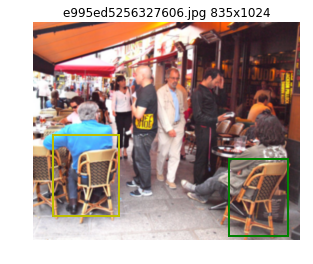

In [167]:
def reverse_retinanet_bbox_to_fraction(image, bbox_scaled):
    """
    Retinanet bbox format:
    x1, y1, x2, y2 in absolute of xsize and ysize
    
    Visual Relationship bbox format:
    XMin, XMax, YMin, YMax in fraction of size
    """
    ysize = image.shape[0]
    xsize = image.shape[1]
    x1, y1, x2, y2 = bbox_scaled
    Xmin = float(min(x1, x2))/xsize
    Xmax = float(max(x1, x2))/xsize
    Ymin = float(min(y1, y2))/ysize
    Ymax = float(max(y1, y2))/ysize
    
    return [Xmin, Xmax, Ymin, Ymax]

def y_from_retinanet_to_model(image, bbox_scaled, score, label, labels_to_names_dict):
    """
    Convert the y of the inference output from from retinanet to y for our model
    """
    return (reverse_retinanet_bbox_to_fraction(image, bbox_scaled), labels_to_names_dict[label][1], score)

# Test the above
print ('Image shape: {}'.format(image_orig.shape))
box, score, label = box_score_label_list[0]
box_scaled = box /scale
print(box_scaled)
y = y_from_retinanet_to_model(image_orig, box_scaled, score, label, labels_to_names)
print ('y for model: {}'.format(y))

# plot the top two bounding boxes to verify accuracy of conversion
box, score, label = box_score_label_list[1]
box_scaled = box /scale
print(box_scaled)
y2 = y_from_retinanet_to_model(image_orig, box_scaled, score, label, labels_to_names)
print ('y2 for model: {}'.format(y2))

bboxes_input = y[0] + y2[0]
print ('bboxes_input: {}, type: {}'.format(bboxes_input, type(bboxes_input)))
show_images([cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)], [os.path.basename(image_file[0])], [bboxes_input])

In [3]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input(
    prefix='data/raw', train_csv_fname = 'challenge-2018-train-vrd.csv', 
    labels_csv_fname_list = ['class-descriptions-boxable.csv', 'class-descriptions.csv'])
xy_full_list, X_full_id_to_file_dict = get_data_from_dir_recursive(xy_list, dir_input='raw')

Label2 missing: /m/02gy9n, label1 : Bottle, relation: is
Missing label count: 20644
Processing dir: data/processed/raw, image count: 0
Processing dir: data/processed/raw/train_01, image count: 11290
Processing dir: data/processed/raw/train_06, image count: 10789
Processing dir: data/processed/raw/train_07, image count: 10890
Processing dir: data/processed/raw/train_04, image count: 11316
Processing dir: data/processed/raw/train_05, image count: 11108
Processing dir: data/processed/raw/train_00, image count: 11310
Processing dir: data/processed/raw/train_08, image count: 7368
Processing dir: data/processed/raw/test, image count: 0
Processing dir: data/processed/raw/train_02, image count: 11209
Processing dir: data/processed/raw/train_03, image count: 11219


In [27]:
def prepare_stage2_input(image_file, infer_model, labels_to_names_dict, min_side=343, max_side=514, top_k=100):
    image_orig = read_image_bgr(image_file)

    # preprocess image for network
    image = preprocess_image(image_orig)
    image, scale = resize_image(image, min_side=min_side, max_side=max_side)

    boxes, scores, labels = retinanet_model_infer.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    
    # visualize detections
    box_score_label_list = [ x for x in zip(boxes[0], scores[0], labels[0]) ]
    box_score_label_list = sorted(box_score_label_list, key=lambda x: x[1], reverse=True)[0:top_k]
    
    ret_list = []
    for box, score, label in box_score_label_list:
        if label == -1:
            continue
        ret_list.append(y_from_retinanet_to_model(
            image_orig, box, score, label, labels_to_names_dict=labels_to_names_dict))
    return ret_list

def _infer_prep_single_helper(fid, image_file, min_side=343, max_side=514):
    image_orig = read_image_bgr(image_file)
    image, scale = resize_image(image_orig, min_side=min_side, max_side=max_side)
    image = preprocess_image(image_orig)
    return fid, image, scale
        
def _infer_prep_helper(fid_file_list, prefix='data/preprocessed', 
                       output_dir='retinanet_infer_input', 
                       min_side=343, max_side=514):
    ret_list = []
    time_read = 0
    time_resize = 0
    time_preprocess = 0
    time_write = 0
    list_size = len(fid_file_list)
    output_dir = os.path.join(os.getcwd(), os.path.join(prefix, output_dir))
    os.makedirs(output_dir, exist_ok=True)
    for fid, image_file in tqdm(fid_file_list):
        #image_orig = read_image_bgr(image_file)
        out_file = os.path.join(output_dir, os.path.basename(image_file))
        if os.path.isfile(out_file):
            continue
        start = time.time()
        image_orig = cv2.imread(image_file, cv2.IMREAD_COLOR) # No need for RGB we are writing to disk
        time_read += time.time() - start
        start = time.time()
        image, scale = resize_image(image_orig, min_side=min_side, max_side=max_side)
        time_resize += time.time() - start
        start = time.time()
        image = preprocess_image(image_orig)
        time_preprocess += time.time() - start
        start = time.time()
        cv2.imwrite(out_file, image)
        time_write += time.time() - start
        ret_list.append((fid, scale))
    return ret_list, int(time_read), int(time_resize), int(time_preprocess), int(time_write)

def _infer_prep_dict_helper(fid_file_dict, min_side=343, max_side=514, limit=None):
    aprun = parallel.ParallelExecutor(n_jobs=8)
    
    fid_file_list = list(fid_file_dict.items())
    if limit is None:
        max_limit = len(fid_file_list)
    else:
        max_limit = min(limit, len(fid_file_list))

    fid_file_list = fid_file_list[0:max_limit]
    
    chunked_list = list(chunks(fid_file_list, int(max_limit/8)))

    print ('chunk list size: {}'.format(len(chunked_list)))

    out_list = aprun(bar='tqdm')(delayed(_infer_prep_helper)(fid_file_list, min_side=343, max_side=514) 
                                         for fid_file_list in chunked_list)
    
    
    ret_dict = {}
    for l in out_list:
        for fid, image, scale in l:
            ret_dict[fid] = (image, scale)
    return ret_dict

def infr_prep_helper(train_set, min_side=343, max_side=514):
    aprun = parallel.ParallelExecutor(n_jobs=4)
    
    chunked_list = list(chunks(list(zip(train_set['features'], train_set['labels_orig'])), 
                                        int(len(train_set['features'])/8)))
    
    print ('chunk list size: {}'.format(len(chunked_list)))

    out_list = aprun(bar='tqdm')(delayed(_infer_prep_helper)(xy_list, min_side=343, max_side=514) 
                                          for xy_list in chunked_list)
    ret_dict = {'features': [], 'scales':[], 'labels_orig': []}
    for l in out_list:
        for image, scale, label in l:
            ret_dict['features'].append(image)
            ret_dict['scales'].append(scale)
            ret_dict['labels_orig'].append(label)
    return ret_dict

data_stage2_set = {'features' : [], 'labels_orig': []}
def group_by_xy_size(train_set, min_side=343, max_side=514):
    group = {}
    for image_file, label in zip(train_set['features'], train_set['labels_orig']):
        image_orig = read_image_bgr(image_file)
        image, scale = resize_image(image_orig, min_side=min_side, max_side=max_side)
        image = preprocess_image(image_orig)
        if image.shape in group:
            group[image.shape]['features'].append(image)
            group[image.shape]['labels_orig'].append(label)
        else:
            group[image.shape] = {'features':[image], 'labels_orig':[label]}
    
    return group

#group_by_xy_size_dataset = group_by_xy_size(dataset_model_train, min_side=343, max_side=514)
#for k, v in group_by_xy_size_dataset:
#    print ('Group : {}, size: {}'.format(k, len(v)))

#data_stage2_set['features'] = [prepare_stage2_input(x, retinanet_model_infer, labels_to_names_dict=labels_to_names,
#                                                    min_side=343, max_side=514) for x in dataset_model_train['features']]

In [14]:
# Run in parallel and time it.
# XXX: Parallel taking too long
#start = time.time()
#image_processed_scale_dict = _infer_prep_dict_helper(X_full_id_to_file_dict, min_side=343, max_side=514, limit=1000)
#print("processing time: ", time.time() - start)

chunk list size: 8
processing time:  43.422473669052124


In [15]:
# No parallel
start = time.time()
out_list = []

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    input_list = list(X_full_id_to_file_dict.items())[0:1000]
    chunked_list = list(chunks(input_list, int(len(input_list)/8)))
    futures = {executor.submit(_infer_prep_helper, x): x for x in chunked_list}
    for future in concurrent.futures.as_completed(futures):
        input_tuple = futures[future]
        try:
            out_list.append(future.result())
        except Exception as exc:
            print('%r generated an exception: %s' % (input_tuple, exc))
            raise
print("processing time: ", time.time() - start)

processing time:  19.30004620552063


In [28]:
start = time.time()
input_list = list(X_full_id_to_file_dict.items())
serial_out_list = _infer_prep_helper(input_list, min_side=343, max_side=514)
print ("processing time for {}: {}".format(len(input_list), time.time() - start))
print ('Load time: {}, resize time: {}, pre-processing time: {}, write time: {}'.
       format(serial_out_list[1], serial_out_list[2], serial_out_list[3], serial_out_list[4]))


processing time for 96499: 4149.214824676514
Load time: 1301, resize time: 106, pre-processing time: 503, write time: 2126


In [55]:
# Save the fid to scale pickle file
image_id_to_scale_dict = {}
print ('Storing fid to scale for {} images'.format(len(serial_out_list[0])))
for k, v in serial_out_list[0]:
    image_id_to_scale_dict[k] = v
    
print ('Image id to scale dict: {}'.format(len(image_id_to_scale_dict)))
image_id_to_scale_pickle = 'retinanet_infer_input_id_to_scale.p'
with open(image_id_to_scale_pickle, "wb" ) as f:
    pickle.dump(image_id_to_scale_dict, f)

Storing fid to scale for 95438 images
Image id to scale dict: 95438


### Load the data from pickle

In [53]:
image_id_to_scale_pickle = 'retinanet_infer_input_id_to_scale.p'
image_id_to_scale_dict = {}
with open(image_id_to_scale_pickle, "rb" ) as f:
    image_id_to_scale_dict = pickle.load(f)
print ('Image id to scale dict: {}'.format(len(image_id_to_scale_dict)))
print ('Dict key: {}'.format(list(image_id_to_scale_dict.keys())[0]))

Image id to scale dict: 95438
Dict key: c969770668e7e435


In [58]:
# dict fid to image to scale, xysize
def get_fid_image_details_dict(id_to_scale_dict,
                               prefix='data/preprocessed', 
                               preproc_dir='retinanet_infer_input'):
    input_dir = os.path.join(os.getcwd(), os.path.join(prefix, preproc_dir))
    ret_dict = {}
    for k, v in tqdm(id_to_scale_dict.items()):
        f = os.path.join(input_dir, str(k)+".jpg")
        img_rgb_processed = cv2.cvtColor(cv2.imread(f, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        ret_dict[f] = (img_rgb_processed, v)    
    return ret_dict

In [ ]:
start = time.time()
image_id_processed_image_scale = get_fid_image_details_dict(image_id_to_scale_dict, 
                                                            preproc_dir='retinanet_infer_input')
print ("Load time time for {}: {}".format(len(input_list), time.time() - start))

In [6]:
import pickle
train_model_pickle ='fullsize_train_model.p'
test_model_pickle = 'fullsize_test_model.p'
with open(train_model_pickle, "rb" ) as f:
    dataset_model_train = pickle.load(f)
with open(test_model_pickle, "rb") as f:
    dataset_model_test = pickle.load(f)

### Load the images and prep for the network.

In [7]:
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image, compute_resize_scale

In [8]:
from log_progress import log_progress

image_processed_dict = {}
def process_data_sets_for_model(dataset_raw, min_side=256, max_side=427, mode='caffe', count = None):
    dataset_processed = {'features': [], 'scale': [], 'labels': [], 'labels_orig': []}
    c = 0
    for x, y in log_progress(iter(zip(dataset_raw['features'], dataset_raw['labels_orig'])), every=10):
        if c >= count:
            break
        c += 1
        img = None
        if x in image_processed_dict:
            img = image_processed_dict[x]
        else:
            img = read_image_bgr(x)
            if img.shape[0] > img.shape[1]:
                scale = float(min_side)/img.shape[0]
            else:
                scale = float(max_side)/img.shape[1]
            #img, scale = resize_image(img, min_side=min_side, max_side=max_side)
            img = cv2.resize(img,(min_side, max_side))         
            img = preprocess_image(img, mode=mode)
            image_processed_dict[x] = img
        dataset_processed['features'].append(img)
        dataset_processed['scale'].append(scale)
        dataset_processed['labels_orig'].append(y)
    return dataset_processed
    
dataset_train_processed = process_data_sets_for_model(dataset_model_train, count=5000)
dataset_test_processed = process_data_sets_for_model(dataset_model_test, count=1000)

### Use Multi Label Binarizer to encode the labels for the images.
Split the data into training and test sets.

In [9]:
print ('Training data set size: {}'.format(len(dataset_train_processed['features'])))
print ('Test data set size: {}'.format(len(dataset_test_processed['features'])))  

print ('Before Multi-Encoding eature shape: {}, label: {}'.format(dataset_train_processed['features'][0].shape, dataset_train_processed['labels_orig'][0]))

# Multi-label encoding
mlb = MultiLabelBinarizer()
mlb_fit = mlb.fit(dataset_train_processed['labels_orig'] + dataset_test_processed['labels_orig'])
                  
dataset_train_processed['labels'] = mlb.transform(dataset_train_processed['labels_orig'])
dataset_test_processed['labels'] = mlb.transform(dataset_test_processed['labels_orig'])
                  
print ('After Multi-Encoding eature shape: {}, label: {}'.format(dataset_train_processed['features'][0].shape, dataset_train_processed['labels'][0]))
print('MLB classes size {}, classes: {}'.format(len(mlb.classes_), mlb.classes_))
print ('Training data label set size: {}'.format(len(dataset_train_processed['labels'])))
print ('Test data label set size: {}'.format(len(dataset_test_processed['labels']))) 

Training data set size: 5000
Test data set size: 1000
Before Multi-Encoding eature shape: (427, 256, 3), label: ('/m/04bcr3', '/m/083vt', 'is')
After Multi-Encoding eature shape: (427, 256, 3), label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
MLB classes size 61, classes: ['/m/01226z' '/m/01599' '/m/01940j' '/m/0199g' '/m/019w40' '/m/01_5g'
 '/m/01bl7v' '/m/01mzpv' '/m/01s55n' '/m/01y9k5' '/m/01yrx' '/m/026t6'
 '/m/02jvh9' '/m/02p5f1q' '/m/0342h' '/m/03bt1vf' '/m/03k3r' '/m/03m3pdh'
 '/m/03ssj5' '/m/04_sv' '/m/04bcr3' '/m/04ctx' '/m/04dr76w' '/m/04lbp'
 '/m/04yx4' '/m/050k8' '/m/0584n8' '/m/05_5p_0' '/m/05r5c' '/m/05r655'
 '/m/05z87' '/m/071p9' '/m/078jl' '/m/078n6m' '/m/07y_7' '/m/080hkjn'
 '/m/083vt' '/m/09tvcd' '/m/0bt9lr' '/m/0cmx8' '/m/0cvnqh' '/m/0dnr7'
 '/m/0dt3t' '/m/0dv5r' '/m/0dv9c' '/m/0h2r6' '/m/0h8my_4' '/m/0hg7b'
 '/m/0k4j' '/m/0l14j_' '/m/0pg52' '/m/0wdt60w' 'at' 'hits' 'holds'
 'inside_of

### Triplet Relation model.
We will use the trained Retinanet model which will output bounding boxes proposals and labels for them. We will add few more layers on top of the model and add add logit at the end.

In [10]:
print ('Retinanet pre model output: {}'.format(retinanet_model.outputs))
print ('Retinanet pre model output-1: {}'.format(retinanet_model.layers[-1].output))
print ('Retinanet pre model output-2: {}'.format(retinanet_model.layers[len(retinanet_model.layers)-2].output))

Retinanet pre model output: [<tf.Tensor 'regression_1/concat:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'classification_1/concat:0' shape=(?, ?, 61) dtype=float32>]
Retinanet pre model output-1: Tensor("classification_1/concat:0", shape=(?, ?, 61), dtype=float32)
Retinanet pre model output-2: Tensor("regression_1/concat:0", shape=(?, ?, 4), dtype=float32)


In [11]:
from keras_retinanet.utils.model import freeze
from keras.layers.merge import Concatenate
from keras.layers import GlobalAveragePooling1D
def RelationshipModel(input_model, output_size):
    """
    Model is regular CNN without Pooling for some or all layers
    """
    # Taken from https://github.com/fizyr/keras-retinanet
    assert(all(output in input_model.output_names for output in ['regression', 'classification'])), \
        "Input is not a training model (no 'regression' and 'classification' outputs were found, outputs are: {}).".format(input_model.output_names)

    print ('Retinanet pre model output: {}'.format(input_model.outputs))
    print ('Retinanet pre model output-1: {}'.format(input_model.layers[-1].output))
    """
    input_model.layers.pop()
    input_model.outputs = [model.layers[-1].output]
    input_model.layers[-1].outbound_nodes = []
    """

    input_model = freeze(input_model)       

    # Layer 1
    model = Concatenate()([input_model.outputs[0], input_model.outputs[1]])
    #model = GlobalAveragePooling1D(name="pool_last")(model)
    #model = Flatten()(model)
    model = Dense(256, activation='relu')(model)
    # Output Layer
    model = Dense(output_size, activation='sigmoid')(model)

    return keras.models.Model(inputs=input_model.inputs, outputs=model, name="triplet_relation")

### Loss function and Optimization

We use the **Focal** loss function and **Adam** optimizer. Batch size is set to 64 and number of default epochs are 32.
**We note that more investigation is need to find out a correct loss function and an accuracy measure to help SGD find the optimal weights.**

In [12]:
from keras_retinanet import losses

def train_model(model, x_train, y_train, learn_rate=0.001, epochs=32, batch_size=64, verbose=1):
    """
    Train the model.
    Using as loss function and Adam optimizer, default learning rate is .001
    """
    model.compile(loss=losses.focal(), 
        optimizer=keras.optimizers.adam(lr=learn_rate, decay=learn_rate / epochs), metrics=['accuracy'])
    return model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
        verbose=verbose, validation_split=0.2, shuffle=True)

In [13]:
# Get the model
print ('Retinanet model input: {}'.format(retinanet_model.input.shape))
model = RelationshipModel(retinanet_model, output_size=len(mlb.classes_))
model.summary()

# Train the model
epochs = 4
batch_size = 8
print ('Shape data: {}, type: {}, type array: {}'.format(dataset_train_processed['features'][0].shape,
                                        type(dataset_train_processed['features'][0]),
                                                        type(dataset_train_processed['features'])))
for x in dataset_train_processed['features']:
    if x.shape != dataset_train_processed['features'][0].shape:
        print (x.shape)
        assert False

X_train = np.array(dataset_train_processed['features'])
print ('Shape np.array data: {}'.format(X_train.shape))
y_train = np.array(dataset_train_processed['labels'])
model_history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size)

Retinanet model input: (?, ?, ?, 3)
Retinanet pre model output: [<tf.Tensor 'regression_1/concat:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'classification_1/concat:0' shape=(?, ?, 61) dtype=float32>]
Retinanet pre model output-1: Tensor("classification_1/concat:0", shape=(?, ?, 61), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
____

Shape np.array data: (5000, 427, 256, 3)
Train on 4000 samples, validate on 1000 samples
Epoch 1/4


ValueError: Cannot feed value of shape (8, 61) for Tensor 'dense_2_target:0', which has shape '(?, ?, ?)'

### Save the model
Save the model that has been trained.

In [ ]:
# Save the weights.
model.save_weights('model_weights.h5')

# Save the model architecture.
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
# Save the MLB labels for later use.
with open("mlb_labels.p", "wb") as f:
    f.write(pickle.dumps(mlb))

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), model_history.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), model_history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("model_training_plot.png")

### Invalid accuracy score of test set.
Due to multi-label classification problem the accuracy is artificially high due the fact that many labels are correctly classified as False.

In [ ]:
# evaluate the model
scores = model.evaluate(np.array(dataset_test_processed['features']), np.array(dataset_test_processed['labels']))
print('\n{}: {}'.format(model.metrics_names[1], scores[1]*100))

In [ ]:
pred = model.predict(np.expand_dims(X_train[0], axis=0))
print('Pred : {}'.format((pred * 100).flatten().tolist()))
print('Truth: {}'.format(y_train[0].flatten().tolist()))

def check_pred(pred, ground):
    pred = pred.flatten().tolist()
    ground = ground.flatten().tolist()
    max_check = float('-inf')
    
    # Get the maximum in pred not corresponding to
    # categories set to true in ground.
    l = [] # Save the ground indices where True exists.
    for i in range(0, len(ground)):
        if ground[i] == 0:
            max_check = max(max_check, pred[i])
        else:
            l.append(i)
    
    # Check that all other elements that do not
    # correspond to prediction do not exceed the minumum above.
    count = 0
    for i in l:
        if max_check < pred[i]:
            count +=1
    
    # Did we get all, if not how many?.
    return count == len(l), count

print ('check_pred: {}'.format(check_pred(pred, y_train[0])))

### Test set error calculation
Iterate through every test set example get the prediction using the model and check with the available label.

In [ ]:
def accuracy_calc_helper(feature_set, label_set):
    accurate_prediction_count_dict = {0: [], 1: [], 2: [], 3:[]}
    for i in range(0, len(feature_set)):
        pred = model.predict(np.expand_dims(feature_set[i], axis=0))
        success, success_count = check_pred(pred, label_set[i])
        if success:
            assert success_count == 3
        accurate_prediction_count_dict[success_count].append((i, pred))

    acc_percentages = {}
    for k, v in accurate_prediction_count_dict.items():
        acc_percentages[k] = str(round(len(v)*100.0/len(feature_set), 2))+'%'
        
    return accurate_prediction_count, acc_percentages

accurate_prediction_count, acc_percentages = accuracy_calc_helper(X_test, y_test)

print('Total Test samples: {}, Accuracy percentage map: {}'.format(len(X_test), acc_percentages))

### Train set error calculation
Let us check if network is actually working for the training set.
We showcase here the pitfall of loss function used in training which gives a wrong idea of accuracy at training time.

In [ ]:
accurate_prediction_count, acc_percentages = accuracy_calc_helper(X_train, y_train)
print('Total Train samples: {}, Accuracy percentage map: {}'.format(len(X_train), acc_percentages))

### Summary

Things to do.

1. Investigate a better loss function and different network architectures. 
2. Incorporate advances in semantic segmentation networks by using the bounding box data. 
3. Investigate which pre trained network to use to help with object detection part of the network.
4. Investigate the feasibility of mining language data.